In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_books = pickle.load(open('df_books.pickle','rb'))
df_books.dropna(subset=['isbn'], axis=0, inplace=True)

## Content Based

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)
series_M = mlb.fit_transform(df_books['series'])

mlb1 = MultiLabelBinarizer(sparse_output=True)
authors_M = mlb1.fit_transform(df_books['authors'])

In [4]:
series_M.shape, authors_M.shape

((789289, 184082), (789289, 461848))

In [5]:
text = df_books['title'] + df_books['genres_new'] + df_books['description'] 
len(text)

789289

### Text Cleaning

In [6]:
# Text Cleaning
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
nltk.download('punkt')

snow = SnowballStemmer('english')

def clean(text):
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
    
def preprocessing(string):
    word_sent = re.sub(r"http\S+", "", string)
    word_sent = clean(word_sent)
    word_sent = re.sub('[^A-Za-z]+', ' ', word_sent)   # removing non-word characters
    word_sent = word_tokenize(word_sent.lower())
    word_sent= ' '.join([snow.stem(word) for word in word_sent])
    word_sent = ' '.join([w for w in word_sent.split() if len(w)>1])
    return word_sent

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
text = text.apply(preprocessing)

### TDIDF & SVD

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=0.0005,max_df=0.7, stop_words='english', dtype= np.float32)
text_M = tfidf_vect.fit_transform(text)

In [9]:
del text

In [10]:
list(tfidf_vect.vocabulary_.keys())[:50]

['alway',
 'thought',
 'normal',
 'teenag',
 'work',
 'intern',
 'paranorm',
 'contain',
 'agenc',
 'fall',
 'shape',
 'shifter',
 'onli',
 'glamour',
 'dream',
 'haunt',
 'voic',
 'cryptic',
 'messag',
 'realiz',
 'center',
 'dark',
 'faeri',
 'propheci',
 'promis',
 'destruct',
 'creatur',
 'storm',
 'return',
 'thrill',
 'new',
 'novel',
 'grand',
 'master',
 'adventur',
 'york',
 'time',
 'bestsel',
 'author',
 'investig',
 'toxic',
 'outbreak',
 'caribbean',
 'sea',
 'ultim',
 'threaten',
 'unit',
 'state',
 'unwit',
 'becom']

In [11]:
from scipy.sparse import hstack
full_M = hstack([series_M, authors_M, text_M])

In [12]:
# Reduce dimension and compress the matrix by SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
svd.fit(full_M)
#print(latent_matrix.shape)

TruncatedSVD(n_components=300)

In [13]:
del full_M

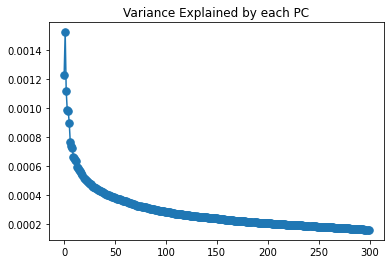

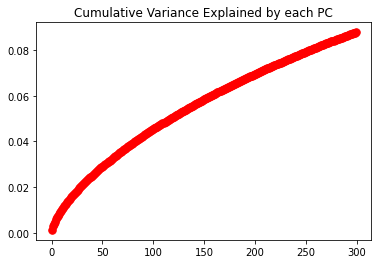

In [14]:
expl = svd.explained_variance_ratio_
plt.plot(expl, '.-', ms=15)
plt.title('Variance Explained by each PC');
plt.show()

plt.plot(np.cumsum(expl), '.-', ms=15, color='red')
plt.title('Cumulative Variance Explained by each PC');
plt.show()

In [15]:
# Use the text features only
from sklearn.decomposition import TruncatedSVD
svd_text = TruncatedSVD(n_components=300)
svd_text.fit(text_M)

TruncatedSVD(n_components=300)

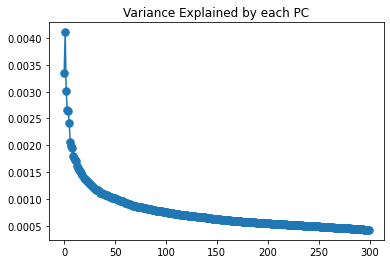

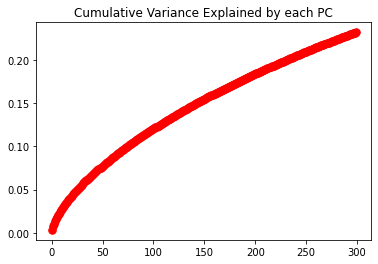

In [16]:
expl = svd_text.explained_variance_ratio_
plt.plot(expl, '.-', ms=15)
plt.title('Variance Explained by each PC');
plt.show()

plt.plot(np.cumsum(expl), '.-', ms=15, color='red')
plt.title('Cumulative Variance Explained by each PC');
plt.show()

It performs better when only text features are considered. and n_components is 300 due to computational power restriction and elbow theorem.

In [17]:
from scipy import sparse
books_latent = sparse.csr_matrix(svd_text.transform(text_M))

In [24]:
pickle.dump(books_latent,open('latent_matrix_books.pickle','wb'))

## Collaborative Filtering

In [18]:
df_reviews = pickle.load(open('/content/drive/MyDrive/Capstone Project (Books Reviews)/df_reviews.pickle','rb'))
df_reviews = df_reviews[df_reviews['work_id'].isin(df_books['work_id'])]

In [19]:
df_reviews.head()

,user_id,book_id,rating,has_spoiler,review_sentences,work_id,title,language_code
0,0,18245960,5,1,"[[0, 'This is a special book.'], [0, 'It start...",25696480,The Three-Body Problem (Remembrance of Earth’s...,NaN
1,0,16981,3,0,"[[0, 'Recommended by Don Katz.'], [0, 'Avail f...",170957,Invisible Man,NaN
2,0,28684704,3,1,"[[0, 'A fun, fast paced science fiction thrill...",43161998,Dark Matter,NaN
3,0,27161156,0,0,"[[0, 'Recommended reading to understand what i...",47200486,Hillbilly Elegy: A Memoir of a Family and Cult...,NaN
4,0,25884323,4,1,"[[0, 'I really enjoyed this book, and there is...",42742263,Aurora,NaN


In [20]:
ratingmatrix = pd.pivot_table(df_reviews, values='rating',index=['work_id'], columns=['user_id'])
ratingmatrix.fillna(0, inplace=True)
ratingmatrix.shape

(10800, 18593)

In [23]:
pickle.dump(ratingmatrix,open('latent_matrix_rating.pickle','wb'))

In [22]:
pickle.dump(df_books,open('df_books.pickle','wb'))
pickle.dump(df_reviews,open('df_reviews.pickle','wb'))